In [1]:
#!pip install biopython
from Bio import SeqIO 
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [2]:
import numpy as np
import pandas as pd
import time

In [3]:
reads = list(SeqIO.parse('single_Pfal_dat.fq','fastq'))

In [4]:
reads

[SeqRecord(seq=Seq('TTTCCTTTTTAAGCGTTTTATTTTTTAATAAAAAAAATATAGTATTATATAGTA...TAA'), id='NC_004325.2-100000', name='NC_004325.2-100000', description='NC_004325.2-100000', dbxrefs=[]),
 SeqRecord(seq=Seq('TATATCTTTAAAATGATGTTGCAAATTTATTGAACATGTTAATAAATCATCCTG...TCA'), id='NC_004325.2-99999', name='NC_004325.2-99999', description='NC_004325.2-99999', dbxrefs=[]),
 SeqRecord(seq=Seq('TCATGATTTACATATATTTGTAAAACATATATAATCTGTCCAGACATATTATAT...CTC'), id='NC_004325.2-99998', name='NC_004325.2-99998', description='NC_004325.2-99998', dbxrefs=[]),
 SeqRecord(seq=Seq('AATTAATAATTATTATTATTACATATATATTTGTTATGTTTTGTTATATAATAT...TGT'), id='NC_004325.2-99997', name='NC_004325.2-99997', description='NC_004325.2-99997', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGCTTTTTAAAAATGAAGACAGTGGCAATGGTGTTTACGGTTTTACTTATAAT...ATG'), id='NC_004325.2-99996', name='NC_004325.2-99996', description='NC_004325.2-99996', dbxrefs=[]),
 SeqRecord(seq=Seq('AAAATATTAATATAGAAATGTTAAAAATACGAATCAATTATATTTGTGATAAAG...TAT'), id='NC_004325

In [5]:
Genome = list(SeqIO.parse('data','fasta'))

In [6]:
Genome

[SeqRecord(seq=Seq('TGAACCCTaaaacctaaaccctaaaccctaaaccctgaaccctaaaccctgaac...agg'), id='NC_004325.2', name='NC_004325.2', description='NC_004325.2 Plasmodium falciparum 3D7 genome assembly, chromosome: 1', dbxrefs=[]),
 SeqRecord(seq=Seq('aaccctaaaccctaaaccctaaaccctaaaccctaaaccctaaacctaaaccct...TCA'), id='NC_037280.1', name='NC_037280.1', description='NC_037280.1 Plasmodium falciparum 3D7 genome assembly, chromosome: 2', dbxrefs=[]),
 SeqRecord(seq=Seq('TAAACCCTAAATCTCTAAACCCTAAAGCTATACCTAAACCCTGAAGGTTATACC...TCA'), id='NC_000521.4', name='NC_000521.4', description='NC_000521.4 Plasmodium falciparum 3D7 genome assembly, chromosome: 3', dbxrefs=[]),
 SeqRecord(seq=Seq('aaccctaaaccctgaaccctaaaccctaaaccctgaaccctgaaccctaaaccc...tta'), id='NC_004318.2', name='NC_004318.2', description='NC_004318.2 Plasmodium falciparum 3D7 genome assembly, chromosome: 4', dbxrefs=[]),
 SeqRecord(seq=Seq('ctaaaccctgaaccctaaaccctgaaccctaaaccctaaaccctgaaccctaaa...ggt'), id='NC_004326.2', name='NC_004326.2', de

Pour élaborer votre méthode de mapping, il est nécessaire de pouvoir lire et analyser 
des fichiers de données de séquençage. La première étape du projet consiste donc à prendre 
en main la bibliothèque Biopython pour manipuler les fichiers au format FASTQ.

Dans un second temps, il vous faudra définir une structure de données permettant de 
chercher des mots de longueur fixe (k > 0) à partir d’un texte t de longueur n et capable de 
répondre efficacement aux questions suivantes : 
-  Étant donné un mot w de longueur k, est-il présent (lui ou son complémentaire inversé) dans le texte indexé t ? 
    - le cas échéant, combien de fois apparaît-il (quel est son support), à quelles positions et sur quel brin ? 
 
-  Quel est le mot de longueur k présent à la position i (0<i<=n) dans le texte t ?
 
-  Bonus : proposez une méthode de recherche de sous-séquences approchée autorisant l’alignement de sous-séquences avec un nombre maximal d’erreurs d. 
 
   
Dans le choix de la structure, vous veillerez bien à prendre en compte le fait que : 
1.  le texte t est formé sur un petit alphabet (A, C, G et T) 
2.  le texte t peut-être très grand (n > 109) 
3.  une structure de données peut être constituée de plusieurs structures distinctes.

In [7]:
def complementInverse(w):
    wCI = []
    for i in range(len(w)):
        li = w[-i-1]
        if li not in "ATCG":
            raise Exception("Letter not in alphabet")
        lCI = 'A'*int(li=='T') + 'T'*int(li=='A') + 'C'*int(li=='G') + 'G'*int(li=='C')
        wCI.append(lCI)
    return ''.join(wCI)

In [8]:
testWord = "ATCG"
ansWord = "CGAT"
ans = complementInverse(testWord)
if complementInverse(testWord) != ansWord:
    raise Exception("Wrong result")

In [9]:
def circularShift(T,k):
    if k<0:
        raise Exception("k must be positive")
    return T[k:]+T[0:k]

def BWT(S):
    if S[len(S)-1]!='$':
        S += '$'
        
    circShifts = []
    for k in range(len(S)):
        circShifts.append(circularShift(S,k))
    circShifts.sort()
    
    bwt = []
    for shift in circShifts:
        bwt.append(shift[len(S)-1])
        
    return bwt

In [10]:
testText = "ATGCCTGATCG"
testTextBWT = BWT(testText)

In [11]:
testTextBWT

['G', 'G', '$', 'G', 'T', 'C', 'C', 'T', 'T', 'A', 'C', 'A']

In [12]:
def suffix_list(T): # O(n log n)
    """
    Compute the suffix list
    
    Args:
        T (str): string
    
    Return:
        list of strings: suffix list
    """
    suffix_list = [T[i:] for i in range(len(T))] # O(n)
    sorted(suffix_list,reverse=True) # O(n log n)
    return suffix_list

def suffix_table(T): # O(n log n)
    """
    Compute the suffix table
    
    Args:
        T (str): string
    
    Return:
        list of tuples (suffix,location): suffix table
    """
    suffix_list = [T[i:] for i in range(len(T))] 
    suffix_table = sorted((e,i) for i,e in enumerate(suffix_list))
    return suffix_table

def BWT_suffix_table(T,end_of_string="$"): # O(n log n)
    """
    Compute the BWT from the suffix table
    
    Args:
        T (str): string
        end_of_string (char): end of string character to append
    
    Return:
        bwt (str): BWT
    """
    if T[-1]!=end_of_string :
        T += end_of_string
    ST = suffix_table(T) # O(n log n)
    bwt = ""
    index = []
    for s,i in ST: # O(n)
        bwt += T[i-1]
        index.append(i-1)
    return bwt, index

Let `n` the size of `T`.

Complexity of `suffix_list(T)` :

In [13]:
suffix_list(testText)

['ATGCCTGATCG',
 'TGCCTGATCG',
 'GCCTGATCG',
 'CCTGATCG',
 'CTGATCG',
 'TGATCG',
 'GATCG',
 'ATCG',
 'TCG',
 'CG',
 'G']

In [14]:
suffix_table(testText)

[('ATCG', 7),
 ('ATGCCTGATCG', 0),
 ('CCTGATCG', 3),
 ('CG', 9),
 ('CTGATCG', 4),
 ('G', 10),
 ('GATCG', 6),
 ('GCCTGATCG', 2),
 ('TCG', 8),
 ('TGATCG', 5),
 ('TGCCTGATCG', 1)]

In [15]:
BWT_suffix_table(testText)

('GG$GTCCTTACA', [10, 6, -1, 2, 8, 3, 9, 5, 1, 7, 4, 0])

In [16]:
from collections import Counter 

def occurrence_indexer(S):
    """
    Number of past occurrences of each char in S
    
    Args:
        S (str): string
        
    Return:
        table of int : number of past occurrences of the char
    """
    K = []
    last_index = {}
    for s in S:
        if s not in last_index: 
            last_index[s] = 0
        K.append(last_index[s])
        last_index[s] += 1
    return(K)

def last2first(counts,k,X):
    """
    k + nbr of occurrences of letters < X 
    
    Args:
        counts (Counter): nbr of each char in the text
        k : int
        X : char
        
    Return:
        int : k + nbr of occurrences of letters < X 
    """
    a = [counts[char] for char in counts if char < X]
    return k + sum(a)
    
def efficient_inverse_BWT(bwt,end_of_string="$"):
    """
    Inverse the BWT
    
    Args:
        bwt (str): bwt of a string T
        last_character (char): which is the end of string character?
    
    Return:
        T (str): BWT^{-1} of bwt
    """    
    K = occurrence_indexer(bwt)
    counts = Counter(bwt)
    X = bwt[0]
    k = K[0]
    S = end_of_string
    while X != end_of_string:
        S = X+S
        j = last2first(counts,k,X)
        X = bwt[j]
        k = K[j]
    return(S)

In [17]:
occurrence_indexer(testText)

[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2]

In [18]:
testText

'ATGCCTGATCG'

In [19]:
last2first(Counter(testText),0,"A")

0

In [20]:
#efficient_inverse_BWT(BWT_suffix_table(testText)) == testText + "$"

In [21]:
  def get_first_occurrence(L,X):
    for i,l in enumerate(L):
        if l == X:
            return(i)
        
def pattern_matching_BWT(T,pattern):
    """
    Search a patter in a String using the BWT
    
    Args:
        S (str): string
        pattern (str): pattern
    
    Return:
        bool: true if the pattern is in the string    
    """
    L,_ = BWT_suffix_table(T)
    K = occurrence_indexer(L)
    counts = Counter(L)
    e = 0
    f = len(L)
    i = len(pattern) - 1
    while e < f and i >= 0:
        X = pattern[i]
        first_occurence_in_L_ef = get_first_occurrence(L[e:f],X)
        if first_occurence_in_L_ef is None:
            return False
        else:
            r = first_occurence_in_L_ef+e
        #print(first_occurence_in_L_ef,L[e:f],r,X,L[r])
        
        last_occurence_in_L_ef = get_first_occurrence(L[e:f][::-1],X)
        if last_occurence_in_L_ef is None:
            return False
        else:
            s = f-last_occurence_in_L_ef-1
        #print(last_occurence_in_L_ef,L[e:f],s,X,L[s])
        
        e = last2first(counts,K[r],X)
        f = last2first(counts,K[s],X)+1
        i -= 1
        #print(r,s,e,f)
    return(i<0)



In [22]:
def rankBWT(bwt):
    """
    Number of past occurrences of each char in S
    
    Args:
        S (str): string
        
    Return:
        table of int : number of past occurrences of the char
    """
    K = []
    tot = {}
    for s in bwt:
        if s not in tot: 
            tot[s] = 0
        K.append(tot[s])
        tot[s] += 1
    return(K,tot)
    

In [25]:
def invBWT(bwt,A):
    A = sorted(A)
    #count = {a:0 for a in A}
    count = {}
    K = []
    for i in range(len(bwt)):
        if bwt[i] in count:
            count[bwt[i]] += 1
        else:
            count[bwt[i]] = 1
        K.append(count[bwt[i]])
    X = bwt[0]
    k = K[1]
    S = '$'
    while X != '$':
        S = X+S
        j = k
        i = 0
        while A[i] != X:
            j += count[A[i]]
            i += 1
        X = bwt[j]
        k = K[j]
    return S

In [26]:
def firstColMap(tots):
    """ Return a map from characters to the range of cells in the first
    column containing the character. 
    char : (first index, last index+1)"""
    first = {}
    totc = 0
    for c, count in sorted(tots.items()):
        first[c] = (totc, totc + count)
        totc += count
    return first

In [27]:
import sys

## BAM

In [30]:
#!pip install pysam

In [514]:
import pysam

In [32]:
samfile = pysam.AlignmentFile('./single_Pfal_dat.bam', 'rb')

In [33]:
allMap = samfile.fetch(until_eof=True)

n = int(1e4)
nMap = 1
i = 0
for mapp in allMap:
    print(mapp.qname)

    i += 1
    
        
    print(mapp.pos)
    # on va chercher la lecture correspondante 
    for j in range(len(reads)):
        if reads[j].id == mapp.qname:
            jSearch = j
            readSearch = reads[j].seq
            break
            
    print('Read n°',j) 
    print(reads[jSearch].id)
    foundRead = []
    
    # On vas rechercher le read dans le génome complet
    for k in range(len(Genome)):
        print('Chr',k)
        cutChr = wholeGenomeCutted[k]
        found = searchWord(cutChr, n, len(readSearch), readSearch)
        if len(found) !=0 :
            print(found)
            foundRead.append((k,found))
            break
    if i>=nMap:
        break
        

mapp.qname

reads[jSearch]

foundRead

print(mapp)

allMap_it

allMap_it

# Mapping de reads par recherche de k-mers

Les reads sont découpés en k-mers.

In [ ]:
k = 10 # taille des k-mers
readTest = reads[2].seq

In [ ]:
kmerTest = getKmers(readTest, k)

In [ ]:
len(kmerTest)*k-k+len(kmerTest[len(kmerTest)-1]) == len(readTest)

Est-ce qu'il y a des k-mers en plusieurs exemplaires ?

In [ ]:
len(np.unique(kmerTest)) == len(kmerTest)

On a des k-mers en plusieurs examplaires. Utilisons un dictionnaire pour les stocker avec leurs positions correspondantes dans le read.

In [ ]:
kmerTdict = {k : [] for k in np.unique(kmerTest)}
for i in range(len(kmerTest)):
    kmerTdict[kmerTest[i]].append(i)

In [ ]:
kmerTdict

On va couper tout le génome avec un overlapp de `k`.

In [28]:
def cutSequence(seqToCut, n, k):
    cutSeq = []
    iF = 0
    iL = iF + n

    Continuer = True

    while Continuer:
        if iL >= len(seqToCut):
            Continuer = False
            iL = len(seqToCut)
        cutSeq.append(seqToCut[iF:iL])
        iF += n - k
        iL = iF + n -1
        if Continuer and len(seqToCut) - iF <= k :
            Continuer = False
            
    return cutSeq

wholeGenomeCutted = []
n = int(1e4)

for i in range(len(Genome)):
    chromosome = Genome[i].seq.upper()
    cutChr = cutSequence(chromosome, n, k)
    wholeGenomeCutted.append(cutChr)

Chaque k-mer est positionné dans le génome complet

On essaie avec juste le chr1

In [ ]:
chr1 = wholeGenomeCutted[0]

In [ ]:
kmerTmap = {}
for word in kmerTdict:
    print(word)
    found = searchWord(chr1, n, k, word)
    kmerTmap[word] = found
    print(found)

In [ ]:
kmerTmap

In [ ]:
nKmer = len(kmerTest)

In [ ]:
for k in kmerTmap:
    print(k, len(kmerTmap[k]))

In [ ]:
kmerTest[0]

In [ ]:
kmerTest[-2]

In [ ]:
kmerTmap[kmerTest[0]][0]

In [ ]:
S = str(Genome[0].seq[kmerTmap[kmerTest[0]][1]:kmerTmap[kmerTest[0]][1]+len(readTest)+10].upper())
T = str(readTest)
F,D = Smith_Waterman(S,T,True)
SWmatrix2strings(S,T,D,F)

In [ ]:
sns.heatmap(F)

In [ ]:
sns.heatmap(D)

In [ ]:
np.amax(F)

In [ ]:
reads[2]

In [ ]:
kmerTmap[kmerTest[0]][1]

# All genome

In [57]:
k = 20 # taille des k-mers
readTest = reads[0].seq

from itertools import combinations_with_replacement  
from itertools import permutations  

alpha = ['A','T','C','G']
comb = list(combinations_with_replacement (alpha,k))
perm = []
for i in comb:
    perm += list(permutations(i))
string = []
for i in perm:
    string.append(''.join(i))
    
allKmers = np.unique(string)

In [30]:
import pandas as pd

In [60]:
KmersRead = getKmers(readTest, k)
kmerDict = {k : [] for k in np.unique(KmersRead)}
for i in range(len(KmersRead)):
    kmerDict[KmersRead[i]].append(i)
    
#kmerCount.loc[KmersRead[i],'Total'] += 1

kmerCount = pd.DataFrame(data=0, index=kmerDict.keys(), columns=['Total','Unique'])

for km in kmerDict.keys():
    kmerCount.loc[km,'Total'] = len(kmerDict[km])

kmerCount.loc[:,'Unique'] =  (kmerCount.loc[:,'Total'] == 1)*1

In [61]:
kmerCount

,Total,Unique
AAAAAAAATATAGTATTATA,1,1
AAAAAAATATAGTATTATAT,1,1
AAAAAATATAGTATTATATA,1,1
AAAAATATAGTATTATATAG,1,1
AAAAGATCCATATAAATAAA,1,1
...,...,...
TTTTAATAAAAAAAATATAG,1,1
TTTTATTTTTTAATAAAAAA,1,1
TTTTTAAGCGTTTTATTTTT,1,1
TTTTTAATAAAAAAAATATA,1,1


In [62]:
uniqueKmers = kmerCount.loc[kmerCount.loc[:,'Unique']==1].index

In [63]:
len(uniqueKmers)

81

Chaque k-mer est positionné dans le génome complet

# UNIQUEMENT

In [406]:
import matplotlib.pyplot as plt

In [414]:
import seaborn as sns

In [31]:
def searching(bwt, SAT, W):

    # Not case sensitive, make everything uppercase
    bwt = bwt.upper()
    W = W.upper()
    
    # Perdorm a BWT on text T and get the indexes corresponding to the Suffix Array of T
    #bwt, SAT = BWT_suffix_table(T)
    # LF mapping
    # F = sorted(bwt) # no need to store it
    rank, totCount = rankBWT(bwt)
    Fmap = firstColMap(totCount)
    del totCount

    
    #print('\nbwt :', sys.getsizeof(bwt),
    #'\nSAT :', sys.getsizeof(SAT),
    #'\nrank :', sys.getsizeof(rank),
    #'\nFmap :', sys.getsizeof(Fmap),)

    letter = W[-1] # last letter of the word W
    if letter not in Fmap:
        return -1, "Word not in text"
    fi, li = Fmap[letter] # find occurences of letter in F
    
    for i in range(2,len(W)+1):
        letter = W[-i] # search W by going backward through it
        if letter not in Fmap:
            return -1, "Word not in text"

        j = fi
        foundRankf = False
        while j < li:
            if bwt[j] == letter:
                if not foundRankf:
                    rankf = rank[j] # get the rank of the first occurence of letter (followed by W suffix)
                    foundRankf = True
                rankl = rank[j] # get the rank of the last occurence of letter (followed by W suffix)
            j += 1
        
        if not foundRankf:
            return -1, "Word not in text"
        
        fi, li = Fmap[letter] # find occurences of letter in F
        fi += rankf # find first occurence of letter in F (followed by W suffix)
        li = fi + rankl-rankf +1 # find last occurence of letter in F (followed by W suffix)

    return [x+1 for x in SAT[fi:li]]
    

In [32]:
def searchWord(cutSeq, n, k, words):

    bwtSeq = []
    satSeq = []
    for s in cutSeq:
        bwt, sat = BWT_suffix_table(s)
        bwtSeq.append(bwt)
        satSeq.append(sat)

    foundRead = []
    for i in range(len(cutSeq)):
        res = searching(bwtSeq[i], satSeq[i], words)
        if res[0] != -1 :
            resi = [x+i*(n-k) for x in res]
            foundRead += resi

    return np.unique(foundRead)

In [33]:
def GenomeBWT(genome):
    bwtGen = []
    satGen = []
    
    wholeGenomeCutted = []
    n = int(1e4)
    overlap = 100
    for i in range(len(Genome)):
        chromosome = Genome[i].seq.upper()
        cutChr = cutSequence(chromosome, n, overlap)
        wholeGenomeCutted.append(cutChr)
        
    for c in range(len(genome)):
        print('chr',c)
        chromosome = wholeGenomeCutted[c]
        bwtChr = []
        satChr = []
        for seq in chromosome:
            bwt, sat = BWT_suffix_table(seq)
            bwtChr.append(bwt)
            satChr.append(sat)
        bwtGen.append(bwtChr)
        satGen.append(satChr)
    return (bwtGen,satGen)

In [35]:
def searchChr(bwtChr,satChr, word):
    n = int(1e4)
    overlap = 100

    foundRead = []
    for i in range(len(bwtChr)):
        res = searching(bwtChr[i], satChr[i], word)
        if res[0] != -1 :
            resi = [x+i*(n-overlap) for x in res]
            foundRead += resi

    return np.unique(foundRead)

In [36]:
def searchGen(bwtGen,satGen, word):
   
    foundGen = {}
    for i in range(len(bwtGen)):
        foundChr = searchChr(bwtGen[i],satGen[i], word)
        foundGen[i] = foundChr
        
    return foundGen

In [37]:
def getKmers(read, k):
    read = str(read)
    kmers = []
    iF = 0
    iL = iF + k

    Continuer = True

    while Continuer:
        if iL >= len(read):
            Continuer = False
            iL = len(read)
        kmers.append(read[iF:iL])
        iF +=1
        iL = iF + k
        if Continuer and iF >= len(read):
            Continuer = False
            
    return kmers

In [41]:
def extension(Genome,Chr,lRead,iChr,iRead,margin):
    iStart_ = iChr-iRead
    iStop_ = iStart_+lRead
    iStart = iStart_-margin
    iStop = iStop_+margin
    
    ext = str(Genome[Chr].seq[iStart:iStop]).upper()
    return (ext,iStart,iStop)

In [42]:
def SWmatrix2strings(S,T,D,F):
    """
    Smith-Waterman matrix to aligned strings

    Args:
        S (str): first string
        T (str): second string
        D (np.array or list of lists): Decision matrix

    Returns:
        S_aligned (str): first string aligned
        T_aligned (str): second string aligned
        
    """    
    S_WITH_GAP = -1
    T_WITH_GAP = 1
    S_T_ALIGN = 0
    i,j = np.unravel_index(F.argmax(),F.shape)
    end = (i,j)
    S_aligned = ""
    T_aligned = ""
    while i > 0 and j > 0:
        #print(i,j,T[j-1],S[i-1],D[i,j])
        #print(S_aligned,T_aligned)
        #print(S[i-1], S_aligned)
        if D[i,j] == S_WITH_GAP:
            S_aligned = S[i-1]+S_aligned
            T_aligned = "_"+T_aligned
            #print(S_aligned,T_aligned)
            i -= 1
        elif D[i,j] == T_WITH_GAP:
            T_aligned = T[j-1]+ T_aligned
            S_aligned = "_"+S_aligned
            #print(S_aligned,T_aligned)
            j -= 1
        elif D[i,j] == S_T_ALIGN:
            S_aligned = S[i-1] + S_aligned
            T_aligned = T[j-1] + T_aligned
            #print(S_aligned,T_aligned)
            j -= 1
            i -= 1
        #elif D[i,j] == NO_ALIGN:
        else:
            break
    start = (i,j)
    return(S_aligned,T_aligned,start,end)

def Smith_Waterman(S,T,return_matrix=False):
    """
    Needleman-Wunch 

    Args:
        S (str): first string
        T (str): second string
        return_matrix (bool): If true return matrix, else return the aligned strings

    Returns:
        F,D (np.array, np.array): If return_matrix is true F is the score matrix and D the decision matrix
        S_aligned, T_aligned (str,str): If return_matrix is false first and second strings aligned
        
    """
    T_WITH_GAP = 1
    S_WITH_GAP = -1
    S_T_ALIGN = 0
    NO_ALIGN = 2
    decision = [T_WITH_GAP,S_WITH_GAP,S_T_ALIGN,NO_ALIGN]
    F = np.zeros((len(S)+1,len(T)+1))
    D = np.zeros((len(S)+1,len(T)+1))
    D[0,1:] = T_WITH_GAP 
    D[1:,0] = S_WITH_GAP 
    for i in range(1,len(S)+1):
        for j in range(1,len(T)+1):
            comparison = int(S[i-1]==T[j-1])*2-1
            options = [F[i,j-1] - 1, F[i-1,j] - 1, F[i-1,j-1] + comparison, 0]
            F[i,j] = options[0]
            D[i,j] = T_WITH_GAP
            for o,val in enumerate(options):
                if val > F[i,j]:
                    F[i,j] = val
                    D[i,j] = decision[o]
    if return_matrix:
        return F,D
    else:
        return SWmatrix2strings(S,T,D,F)

On fait la BWT sur notre génome

In [34]:
bwtGen, satGen = GenomeBWT([Genome[0]])

chr 0


On va découper les k-mers dans notre lecture puis les ranger dans :
- KmersRead : string array, chaque k-mers à la suite dans l'ordre de présence dans la lecture
- kmerDict : dict {string : [int]}, correspondance k-mer unique avec toutes ses positions dans la lecture
- uniqueKmers == kmerDict.keys() : string array, liste des k-mers trouvés

In [399]:
k = 9
read = str(reads[2].seq).upper()
KmersRead = getKmers(read, k)
uniqueKmers = np.unique(KmersRead)
kmerDict = {k : [] for k in uniqueKmers}
for i in range(len(KmersRead)):
    kmerDict[KmersRead[i]].append(i)

Les occurences de chaque k-mer sont cherchées dans le génome :
- ChrKmersPos :  [(k-mer, occurence)]
- ChrKmersFound : {k-mer : [occurences]}
- ChrKmersFreq : {k-mer : fréquence dans le chromosome}

In [400]:
ChrKmersPos = []
ChrKmersFound = {}
ChrKmersFreq = {}
for w in uniqueKmers:
    foundChr = searchChr(bwtGen[0],satGen[0], w)
    ChrKmersFound[w] = foundChr
    ChrKmersFreq[w] = len(foundChr)
    for i in foundChr:
        ChrKmersPos.append((w,i))

Les k-mers les plus fréquents sont filtrés. On garde les zones avec une fréquence inférieur au 75e percentile.

In [401]:
ChrKmersPosFilt = []
threshold = np.percentile(list(ChrKmersFreq.values()),75)
for t in ChrKmersPos:
    if ChrKmersFreq[t[0]] < threshold:
        ChrKmersPosFilt.append(t)

Les k-mers trouvés dans le génome sont ordonés dans l'ordre de leur présence dans le chromosome.
- ChrKmersPosFiltdf : DataFrame [k-mer,iChromosome]

In [417]:
test1 = pd.DataFrame(ChrKmersPos, columns=['K-mer','i'])
ChrKmersPosFiltdf = pd.DataFrame(ChrKmersPosFilt, columns=['K-mer','i'])

In [418]:
ChrKmersPosFiltdf = ChrKmersPosFiltdf.sort_values('i')

In [426]:
SortedKmers = list(ChrKmersPosFiltdf.loc[:,'K-mer'])

On essaie de faire correspondre les k-mers trouvés dans le chromosome à ceux de la lecture.

In [428]:
corrRead = [] # indices des k-mers de la lecture mis en correspondance avec les k-mers du génome
i = -1
for k in SortedKmers: # Pour chaque k-mer dans le génome
    i += 1
    listI = kmerDict[k] # liste des positions possibles dans la lecture
    # Si qu'une position ou que début de la mise en correspondance 
    # ou qu'on a déjà une fin de lecture mis en correspondance juste avant
    if len(listI) == 1 or len(corrRead) == 0 or listI[-1]-corrRead[-1]<=0:
        corrRead.append(listI[0]) # on met en correspondance k du génome avec la première occurence de k dans le read
    else:
        # différence entre les posible occurences de k dans read 
        # avec l'index de la dernière correspondance faite
        dist = np.array(listI)-corrRead[-1]
        j = 0
        # on cherche l'occurence pouvant étant après l'index de la dernière correspondance faite
        # et la plus proche de celle-ci
        while dist[j]<=0:
            j+=1
        
        corrRead.append(listI[j])    

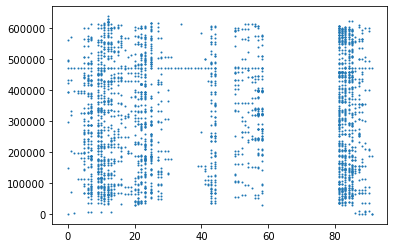

In [437]:
plt.scatter(corrRead,list(ChrKmersPosFiltdf.loc[:,'i']),s=1)

À l'aide d'une fenêtre glissante le long de y, la zone avec la plus forte concentration de k-mers est détectée.

In [408]:
x = corrRead
y = list(ChrKmersPosFiltdf.loc[:,'i'])

In [438]:
yRange = (min(y),max(y))
ySpan = yRange[1]-yRange[0]
epsilon = len(read)*2

In [439]:
mi = yRange[0]
ma = mi+epsilon
i = 0
yMov = [0]*ySpan
for j in range(len(y)):
    if y[j] < ma:
        yMov[i] += 1
    else:
        lastyMov = yMov[i]
        while y[j] >= ma:
            i += 1
            mi += 1
            ma += 1
            yMov[i] = yMov[i-1]
            jMi = j-yMov[i-1]
            while y[jMi] < mi:
                yMov[i] -= 1 
                jMi += 1
        yMov[i] += 1
    

In [499]:
iStart = yMov.index(max(yMov))+yRange[0]
iEnd = iStart + epsilon + int(len(read)/2)

On va prendre les fragments qui correspondent à une lecture à partir de là.

In [506]:
S = str(Genome[0].seq)[iStart:iEnd].upper()
T = read
F,D = Smith_Waterman(S,T,True)
seqChr,seqRead,istart,iend = SWmatrix2strings(S,T,D,F)

In [509]:
mappedTo = (istart[0]+iStart,iend[0]+iStart)
Fscore = np.amax(F)

In [510]:
mappedTo

(471737, 471837)

In [511]:
Fscore

100.0

In [512]:
str(Genome[0].seq)[mappedTo[0]:mappedTo[1]].upper() == seqChr

True

In [513]:
seqChr,seqRead

('TCATGATTTACATATATTTGTAAAACATATATAATCTGTCCAGACATATTATATAATTGATAATATAATATATATATATATATATAAATTATTACTTCTC',
 'TCATGATTTACATATATTTGTAAAACATATATAATCTGTCCAGACATATTATATAATTGATAATATAATATATATATATATATATAAATTATTACTTCTC')

In [519]:
storeMapping = pd.DataFrame(columns=['chr', 'iStart', 'iEnd', 'Fscore'])

In [536]:
this = np.reshape([0,iStart,iEnd,Fscore],(1, 4))

In [538]:
thisMapping = pd.DataFrame(this,index = [reads[0].id],columns=['chr', 'iStart', 'iEnd', 'Fscore'])

In [539]:
storeMapping.append(thisMapping)

,chr,iStart,iEnd,Fscore
NC_004325.2-100000,0.0,471629.0,471879.0,100.0
